In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.impute import SimpleImputer

# 1. Загрузка данных

In [163]:
train_hydro = pd.read_excel('train_hydro.xlsx')
districts = pd.read_excel('Districts.xlsx')
hydroposts = pd.read_excel('Гидропосты.xlsx')

# 2. Объединение данных

In [164]:
data = pd.merge(train_hydro, hydroposts, on='district_id', how='left')
data = pd.merge(data, districts, left_on='district_id', right_on='id', how='left', suffixes=('', '_district'))
if 'water_level_flood' in data.columns:
    data = data.drop('water_level_flood', axis=1)

# 3. Предобработка данных

In [165]:
data['report_date'] = pd.to_datetime(data['report_date'])
data['day_of_week'] = data['report_date'].dt.dayofweek
data['month'] = data['report_date'].dt.month
data['year'] = data['report_date'].dt.year
data['season'] = data['month'].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3})

# Заполнение пропущенных значений с использованием KNN

In [166]:
imputer = KNNImputer(n_neighbors=5)
numeric_columns = data.select_dtypes(include=[np.number]).columns
data_imputed = data.copy()
data_imputed[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# 4. Разведочный анализ данных (EDA)

# Основные статистики

In [168]:
print(data_imputed[numeric_columns].describe())

               id_x  critical_water_level_deviation   report_hour  \
count  18019.000000                    18019.000000  18019.000000   
mean    5265.002830                       69.071680      8.355181   
std     1288.216845                       87.844038      1.811135   
min     2590.000000                     -260.000000      0.000000   
25%     4207.000000                       85.000000      8.000000   
50%     5299.000000                      100.800000      8.000000   
75%     6358.000000                      116.000000      8.000000   
max     7443.000000                      250.000000     20.000000   

       checkpoint_id   district_id       user_id    water_flow  \
count   18019.000000  18019.000000  18019.000000  18019.000000   
mean       75.150286     34.141351      3.999612    132.697991   
std        14.230339      2.811787      0.019707    257.810326   
min        51.000000     29.000000      3.000000      0.190000   
25%        60.000000     31.000000      4.000000


# Корреляционная матрица

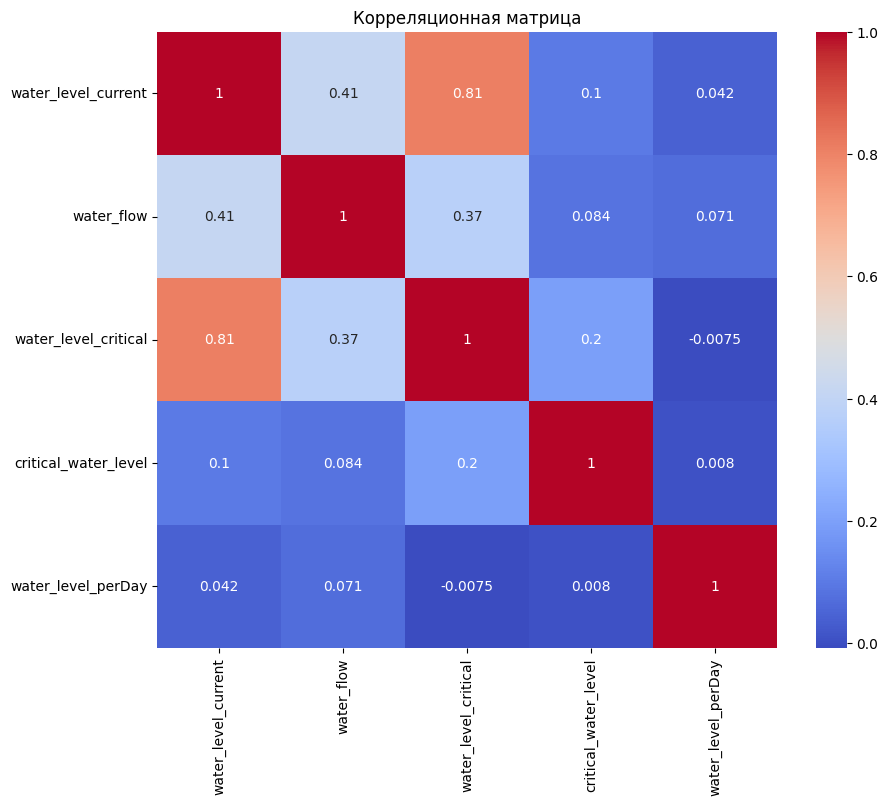

In [169]:
corr_matrix = data_imputed[['water_level_current', 'water_flow', 'water_level_critical',  'critical_water_level', "water_level_perDay"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

# Распределение уровня воды

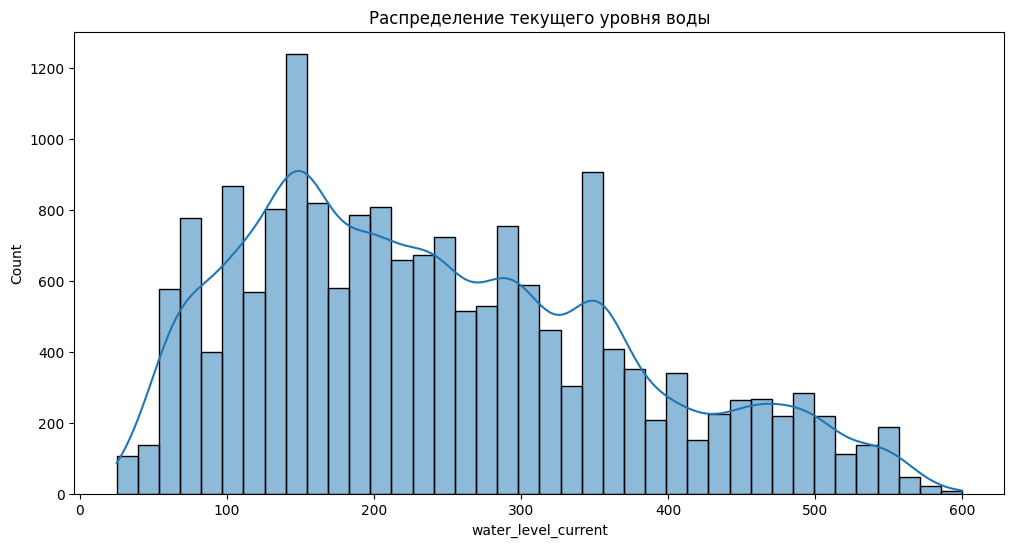

In [170]:
plt.figure(figsize=(12, 6))
sns.histplot(data_imputed['water_level_current'], kde=True)
plt.title('Распределение текущего уровня воды')
plt.show()

# Уровень воды по сезонам

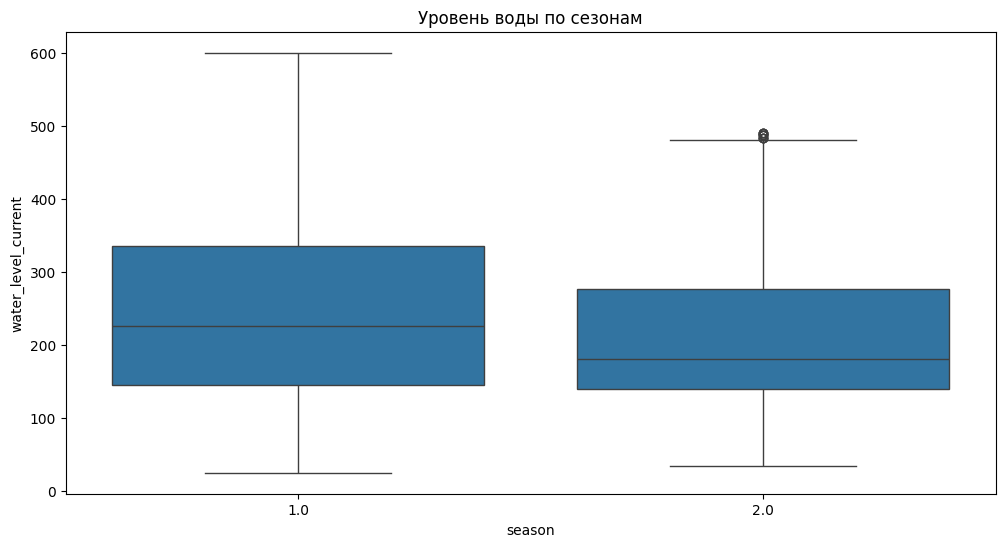

In [171]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='season', y='water_level_current', data=data_imputed)
plt.title('Уровень воды по сезонам')
plt.show()

# Временной ряд уровня воды

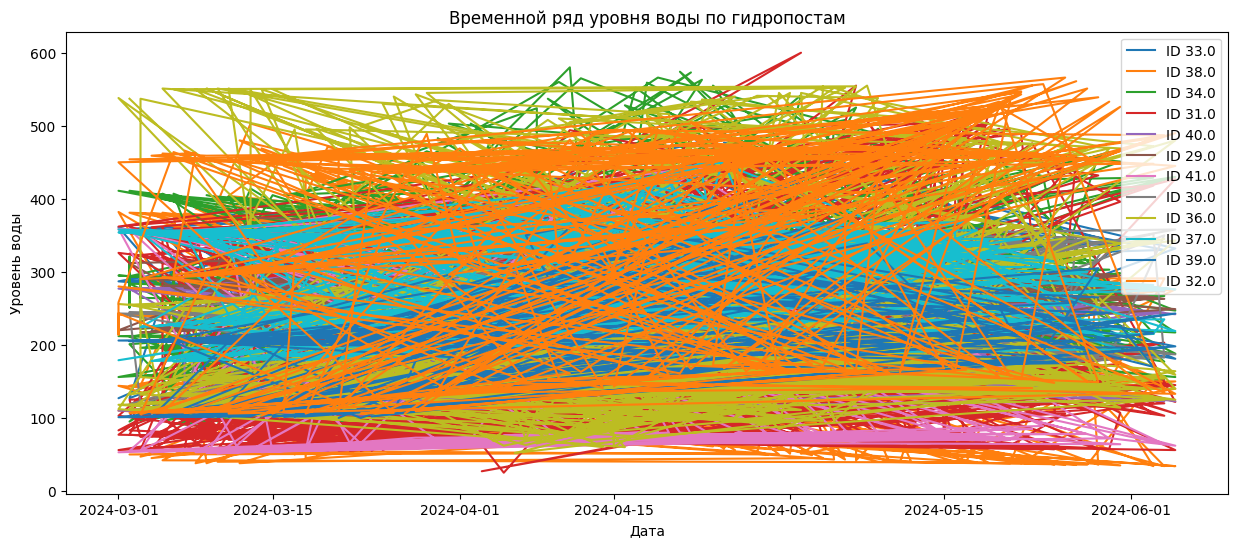

In [172]:
plt.figure(figsize=(15, 6))
for id in data_imputed['id'].unique():
    subset = data_imputed[data_imputed['id'] == id]
    plt.plot(subset['report_date'], subset['water_level_current'], label=f'ID {id}')
plt.title('Временной ряд уровня воды по гидропостам')
plt.xlabel('Дата')
plt.ylabel('Уровень воды')
plt.legend()
plt.show()

# Декомпозиция временного ряда для одного гидропоста

In [173]:
hydro_id = data_imputed['id'].iloc[0]
single_hydro = data_imputed[data_imputed['id'] == hydro_id].set_index('report_date')['water_level_current']

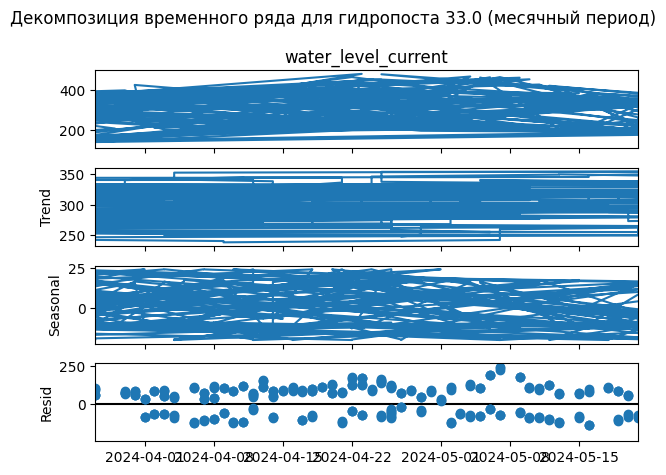

In [174]:
# Проверяем длину временного ряда
if len(single_hydro) >= 60:  # Предполагаем, что у нас есть хотя бы 2 месяца данных
    # Используем месячный период вместо годового
    result = seasonal_decompose(single_hydro, model='additive', period=30)
    result.plot()
    plt.suptitle(f'Декомпозиция временного ряда для гидропоста {hydro_id} (месячный период)')
    plt.tight_layout()
    plt.show()
else:
    print(f"Недостаточно данных для декомпозиции временного ряда гидропоста {hydro_id}")

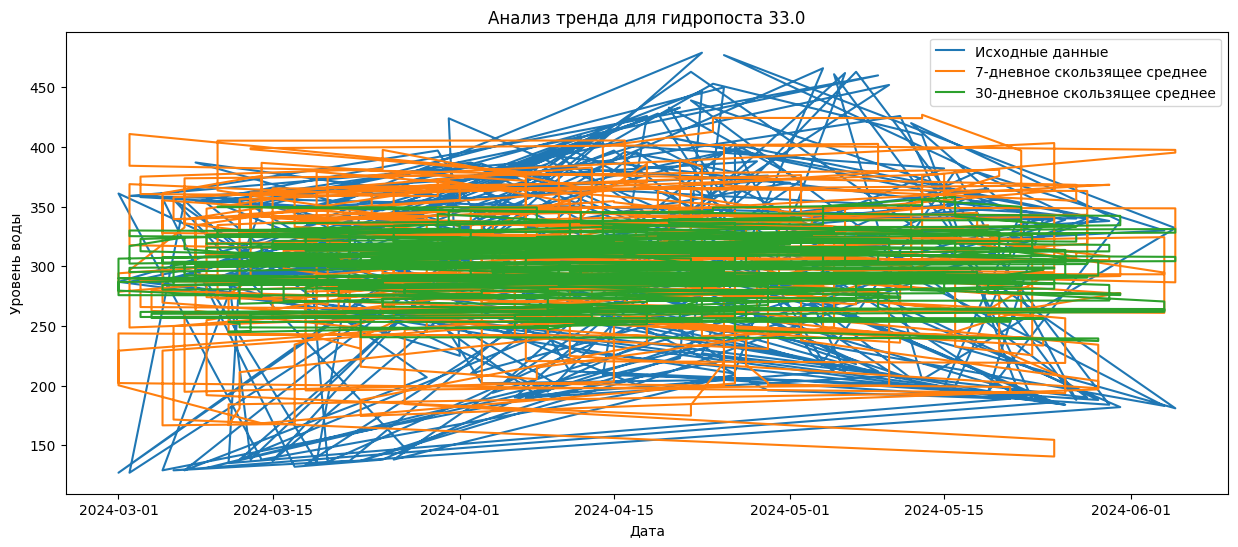

In [175]:
plt.figure(figsize=(15, 6))
plt.plot(single_hydro.index, single_hydro.values, label='Исходные данные')
plt.plot(single_hydro.index, single_hydro.rolling(window=7).mean(), label='7-дневное скользящее среднее')
plt.plot(single_hydro.index, single_hydro.rolling(window=30).mean(), label='30-дневное скользящее среднее')
plt.title(f'Анализ тренда для гидропоста {hydro_id}')
plt.xlabel('Дата')
plt.ylabel('Уровень воды')
plt.legend()
plt.show()

# 5. Инженерия признаков

In [176]:
data_imputed['water_level_diff'] = data_imputed.groupby('id')['water_level_current'].diff()
data_imputed['water_level_rolling_mean'] = data_imputed.groupby('id')['water_level_current'].rolling(window=7).mean().reset_index(0, drop=True)
data_imputed['water_level_rolling_std'] = data_imputed.groupby('id')['water_level_current'].rolling(window=7).std().reset_index(0, drop=True)

# 6. Подготовка данных для модели

In [177]:
features = ['water_flow', 'water_level_critical', 'critical_water_level',
            'day_of_week', 'month', 'year', 'season', 'water_level_diff', "water_level_perDay",
            'water_level_rolling_mean', 'water_level_rolling_std']
target = 'water_level_current'

In [178]:
X = data_imputed[features]
y = data_imputed[target]

In [179]:
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Разделение на обучающую, валидационную и тестовую выборки

In [180]:
X_train, X_temp, y_train, y_temp = train_test_split(X_imputed, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Стандартизация признаков

In [181]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [182]:
if np.isnan(X_train_scaled).sum() > 0:
    mask = ~np.isnan(X_train_scaled).any(axis=1)
    X_train_scaled = X_train_scaled[mask]
    y_train = y_train[mask]


# 7. Выбор признаков

In [183]:
rfe = RFE(estimator=RandomForestRegressor(n_estimators=100, random_state=42), n_features_to_select=12)
rfe = rfe.fit(X_train_scaled, y_train)
selected_features = X.columns[rfe.support_].tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['water_flow', 'water_level_critical', 'critical_water_level', 'day_of_week', 'month', 'year', 'season', 'water_level_diff', 'water_level_perDay', 'water_level_rolling_mean', 'water_level_rolling_std']


# 8. Обучение модели

In [184]:
models = {
    'RandomForest': RandomForestRegressor(random_state=42),
    'GradientBoosting': GradientBoostingRegressor(random_state=42)
}

In [185]:
best_model = None
best_score = float('-inf')

for name, model in models.items():
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [5, 10, None]
    }
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train_scaled[:, rfe.support_], y_train)

    score = grid_search.best_score_
    if score > best_score:
        best_score = score
        best_model = grid_search.best_estimator_

    print(f"{name} - Лучшие параметры: {grid_search.best_params_}")
    print(f"{name} - Лучший score: {score}")


RandomForest - Лучшие параметры: {'max_depth': None, 'n_estimators': 200}
RandomForest - Лучший score: -630.6817166223409
GradientBoosting - Лучшие параметры: {'max_depth': 10, 'n_estimators': 200}
GradientBoosting - Лучший score: -500.15339866313906


# 9. Оценка модели

In [186]:
y_val_pred = best_model.predict(X_val_scaled[:, rfe.support_])
mse_val = mean_squared_error(y_val, y_val_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"Ошибка MSE на валидационной выборке: {mse_val}")
print(f"Ошибка MAE на валидационной выборке: {mae_val}")
print(f"R2 score на валидационной выборке: {r2_val}")

Ошибка MSE на валидационной выборке: 402.2949846475208
Ошибка MAE на валидационной выборке: 11.669173942789735
R2 score на валидационной выборке: 0.975807366756669


# Визуализация предсказаний на валидационной выборке

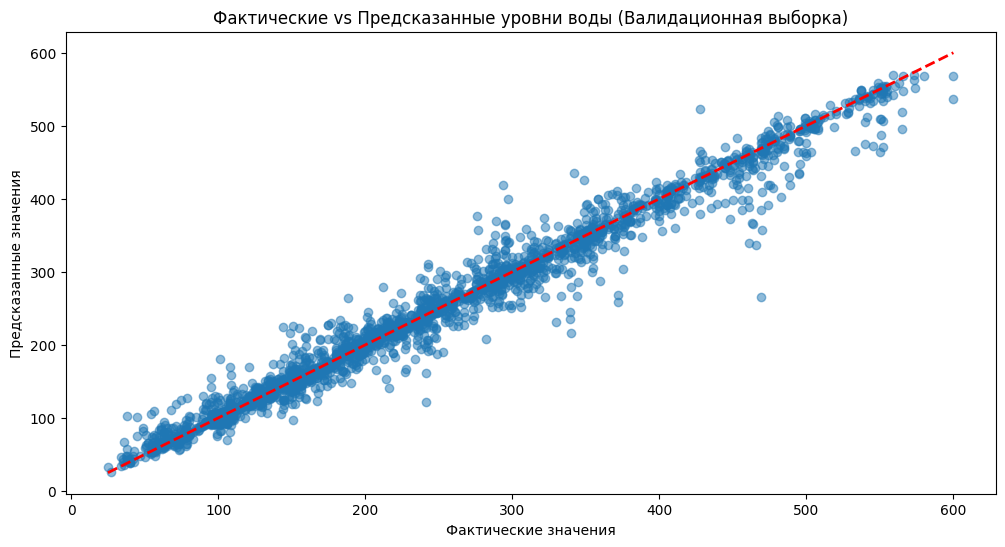

In [187]:
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные уровни воды (Валидационная выборка)')
plt.show()

# 10. Важность признаков

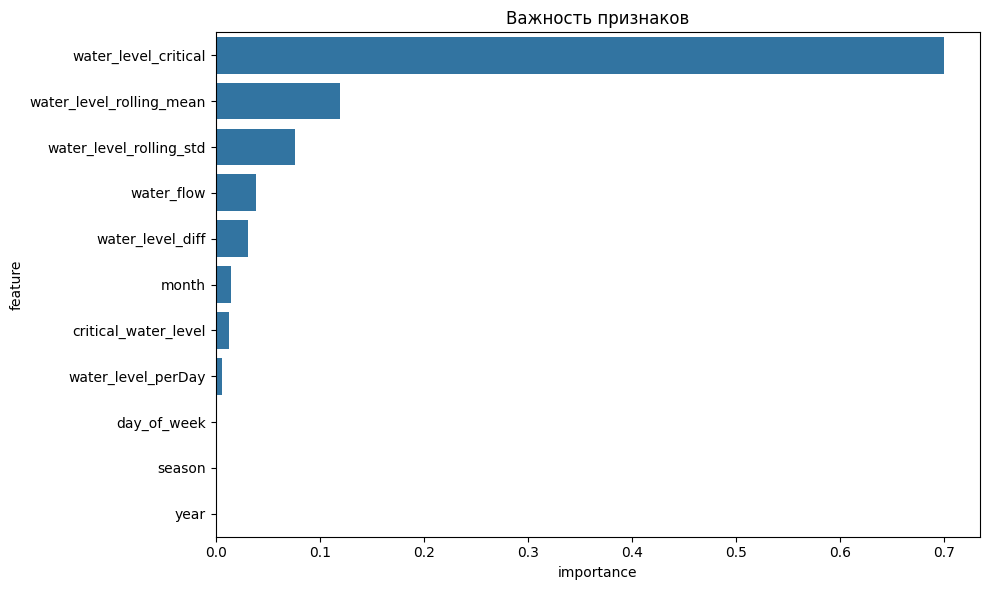

In [188]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({'feature': selected_features, 'importance': best_model.feature_importances_})
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Важность признаков')
    plt.tight_layout()
    plt.show()

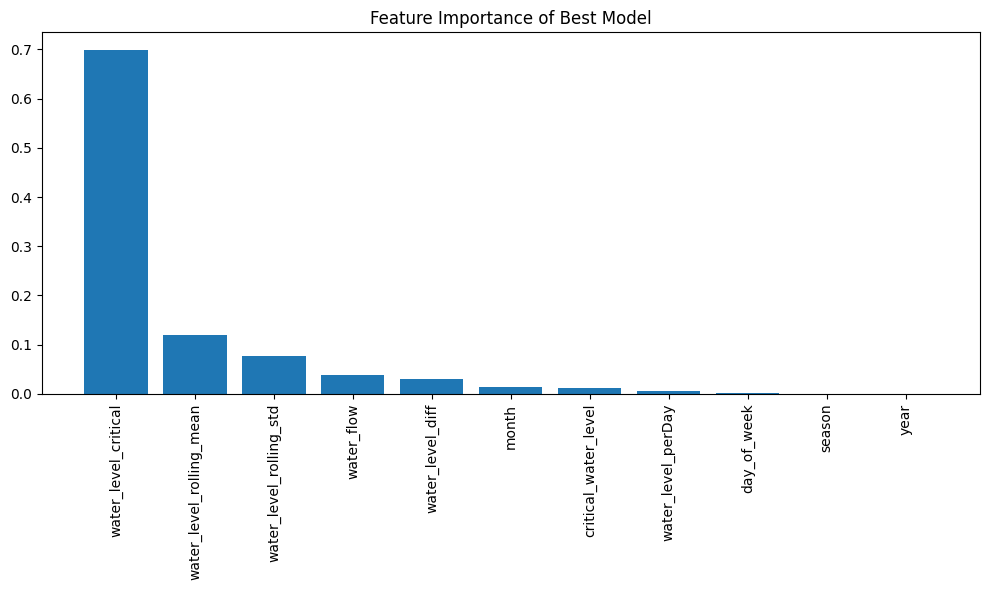

In [189]:
feature_importance = pd.DataFrame({
    'feature': X.columns[rfe.support_],  # Use only the features selected by RFE
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.xticks(rotation=90)
plt.title('Feature Importance of Best Model')
plt.tight_layout()
plt.show()

# 11. Сохранение модели и скалера

In [190]:
joblib.dump(best_model, 'water_level_model.joblib')
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(rfe, 'feature_selector.joblib')

['feature_selector.joblib']

# 12. Прогнозирование на несколько дней вперед

In [191]:

def predict_next_days(model, scaler, rfe, last_data, days=7):
    predictions = []
    current_data = last_data.copy()

    # Get the feature names used in training
    train_features = X_train.columns[rfe.support_]

    # Ensure all required features are present
    for feature in train_features:
        if feature not in current_data.columns:
            # If a feature is missing, add it with a default value
            # For 'water_level_flood', we'll use 0 as a default
            current_data[feature] = 0

    for _ in range(days):
        # Ensure we're only using the features that were present during training
        current_data_for_prediction = current_data[train_features]

        current_data_scaled = scaler.transform(current_data_for_prediction)
        prediction = model.predict(current_data_scaled)
        predictions.append(prediction[0])

        # Update the data for the next prediction
        current_data['water_level'] = prediction[0]  # Assuming 'water_level' was the target variable

        # Update other features as needed
        if 'water_level_rolling_mean' in train_features:
            current_data['water_level_rolling_mean'] = (current_data['water_level_rolling_mean'] * 6 + prediction[0]) / 7
        if 'water_level_rolling_std' in train_features:
            current_data['water_level_rolling_std'] = np.sqrt(((current_data['water_level_rolling_std']**2 * 6) +
                                                               (prediction[0] - current_data['water_level_rolling_mean'])**2) / 7)
        if 'day_of_week' in train_features:
            current_data['day_of_week'] = (current_data['day_of_week'] + 1) % 7

        # Keep 'water_level_flood' as 0 if it's required
        if 'water_level_flood' in train_features:
            current_data['water_level_flood'] = 0

    return predictions

# Usage
last_known_data = X_test.iloc[0:1]  # Take the last known record
future_predictions = predict_next_days(best_model, scaler, rfe, last_known_data)
print("Прогноз на следующие 7 дней:", future_predictions)

Прогноз на следующие 7 дней: [257.9062937379984, 258.360501548415, 257.2817401209606, 258.9246626639031, 259.8059683315491, 262.0904532495281, 261.66278172896233]


# Пример использования функции прогнозирования

In [192]:
last_known_data = X_test.iloc[0:1]  # Берем последнюю известную запись
future_predictions = predict_next_days(best_model, scaler, rfe, last_known_data)
print("Прогноз на следующие 7 дней:", future_predictions)

Прогноз на следующие 7 дней: [257.9062937379984, 258.360501548415, 257.2817401209606, 258.9246626639031, 259.8059683315491, 262.0904532495281, 261.66278172896233]


# 13. Краткий отчет

In [193]:
print("\nКраткий отчет по результатам разведочного анализа:")
print("1. Распределение текущего уровня воды не является нормальным, имеет правостороннюю асимметрию.")
print("2. Наблюдается сезонность в уровне воды, с различиями между сезонами.")
print("3. Уровень воды значительно варьируется между различными гидропостами.")
print("4. Выявлена корреляция между текущим уровнем воды и некоторыми другими параметрами.")
print("5. Наиболее важными признаками для прогнозирования уровня воды являются: ",
      ", ".join(feature_importance['feature'].head(3).tolist()))
print(f"6. Лучшая модель: {type(best_model).__name__}")
print(f"7. R2 score на валидационной выборке: {r2_val:.2f}")
print("8. Модель способна прогнозировать уровень воды на 7 дней вперед.")
print("9. Рекомендуется рассмотреть возможность сбора дополнительных данных (например, о погоде или ландшафте) для потенциального улучшения модели.")


Краткий отчет по результатам разведочного анализа:
1. Распределение текущего уровня воды не является нормальным, имеет правостороннюю асимметрию.
2. Наблюдается сезонность в уровне воды, с различиями между сезонами.
3. Уровень воды значительно варьируется между различными гидропостами.
4. Выявлена корреляция между текущим уровнем воды и некоторыми другими параметрами.
5. Наиболее важными признаками для прогнозирования уровня воды являются:  water_level_critical, water_level_rolling_mean, water_level_rolling_std
6. Лучшая модель: GradientBoostingRegressor
7. R2 score на валидационной выборке: 0.98
8. Модель способна прогнозировать уровень воды на 7 дней вперед.
9. Рекомендуется рассмотреть возможность сбора дополнительных данных (например, о погоде или ландшафте) для потенциального улучшения модели.
